In [ ]:
import os
import dynamo as dyn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
dyn.configuration.set_figure_params(dpi=200)

In [16]:
working_directory='/home/jupyter/stochastic_regulation_code/accessory_files/'

In [4]:
adata = dyn.read_h5ad(os.path.join(working_directory,'adata_JL_011_vfinal.h5ad'))

In [5]:
adata.layers['new'], adata.layers['total'] = adata.layers['X_l_TC'], adata.X

for i in ['X_l_TC', 'X_n_TC', 'ambiguous', 'labeled_TC', 
          'sl_TC', 'sn_TC', 'ul_TC', 'un_TC']: 
    del adata.layers[i]
subset = adata[(adata.X > 0).sum(1) > 500, :]
dyn.tl.recipe_deg_data(subset, reset_X=False, tkey='time', n_top_genes=100,
                       X_total_layers=False,
                       splicing_total_layers=False,
                       keep_filtered_cells=True,
                       keep_filtered_genes=True,
                       keep_raw_layers=False,
                       del_2nd_moments=False, # keep 2nd_moments
                       )

|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: deg
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object.
|-----> filtering cells...
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----> 14544 cells passed basic filters.
|-----> filtering gene...
|-----> <insert> pass_basic_filter to var in AnnData Object.
|-----> 7757 genes passed basic filters.
|-----> calculating size factor..

AnnData object with n_obs × n_vars = 14544 × 12262
    obs: 'n_counts', 'n_genes', 'batch', 'time', 'percent_mito', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'gene_name', 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'n_cells-4', 'n_cells-5', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'use_for_dynamics', 'use_for_transition'
    uns: 'batch_colors', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'neighbors', 'dynamics', 'umap_fit', 'grid_velocity_umap'

In [7]:
def r_squared(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    
    return r2


# fast version 
def calc_R2(X, Y, k, f=lambda X, k: np.einsum("ij,i -> ij", X, k)):
    """calculate R-square. X, Y: n_species (mu, sigma) x n_obs"""
    if X.ndim == 1:
        X = X[None]
    if Y.ndim == 1:
        Y = Y[None]
    if np.isscalar(k):
        k = np.array([k])

    Y_bar = np.mean(Y, 1)
    d = Y.T - Y_bar
    SS_tot = np.sum(np.einsum("ij,ij -> i", d, d))

    F = f(X, *k)
    d = F - Y
    SS_res = np.sum(np.einsum("ij,ij -> j", d, d))

    return 1 - SS_res / SS_tot

In [8]:
subset

AnnData object with n_obs × n_vars = 14544 × 12262
    obs: 'n_counts', 'n_genes', 'batch', 'time', 'percent_mito', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'gene_name', 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'n_cells-4', 'n_cells-5', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'use_for_dynamics', 'use_for_transition'
    uns: 'batch_colors', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'neighbors', 'dynamics', 'umap_fit', 'grid_velocity_umap'

In [9]:
sc.pp.filter_genes(subset,min_cells=round(subset.n_obs * 0.2))

In [10]:
"""
compute an exponential decay fit to two vectors of x and y data
result is in form y = a + b * exp(c*x).
ref. https://gist.github.com/johanvdw/443a820a7f4ffa7e9f8997481d7ca8b3
"""
from scipy.optimize import curve_fit


def exp_est(x,y):
    n = np.size(x)
    # sort the data into ascending x order
    y = y[np.argsort(x)]
    x = x[np.argsort(x)]

    Sk = np.zeros(n)

    for n in range(1, n):
        Sk[n] = Sk[n-1] + (y[n] + y[n-1])*(x[n]-x[n-1])/2

    dx = x - x[0]
    dy = y - y[0]

    m1 = np.matrix([[np.sum(dx**2), np.sum(dx*Sk)],
                    [np.sum(dx*Sk), np.sum(Sk**2)]])
    m2 = np.matrix([np.sum(dx*dy), np.sum(dy*Sk)])

    [d, c] = (m1.I * m2.T).flat

    m3 = np.matrix([[n,                   np.sum(np.exp(c*x))],
                    [np.sum(np.exp(c*x)), np.sum(np.exp(2*c*x))]])

    m4 = np.matrix([np.sum(y), np.sum(y*np.exp(c*x).T)])

    [a, b] = (m3.I * m4.T).flat

    return [a, b, c]


def myexp(x, A, B, C):

    return A + B*np.exp(-C*x)


In [11]:
subset.layers['ntr'] = subset.layers['X_new'] / (subset.layers['X_total'].A + 1e-5)

genes = subset.var_names
gamma_vec, half_life = np.zeros(len(genes)), np.zeros(len(genes))
gamma_vec2, half_life2 = np.zeros(len(genes)), np.zeros(len(genes))
r2 = np.zeros(len(genes))

<AxesSubplot:xlabel='time', ylabel='ntr'>

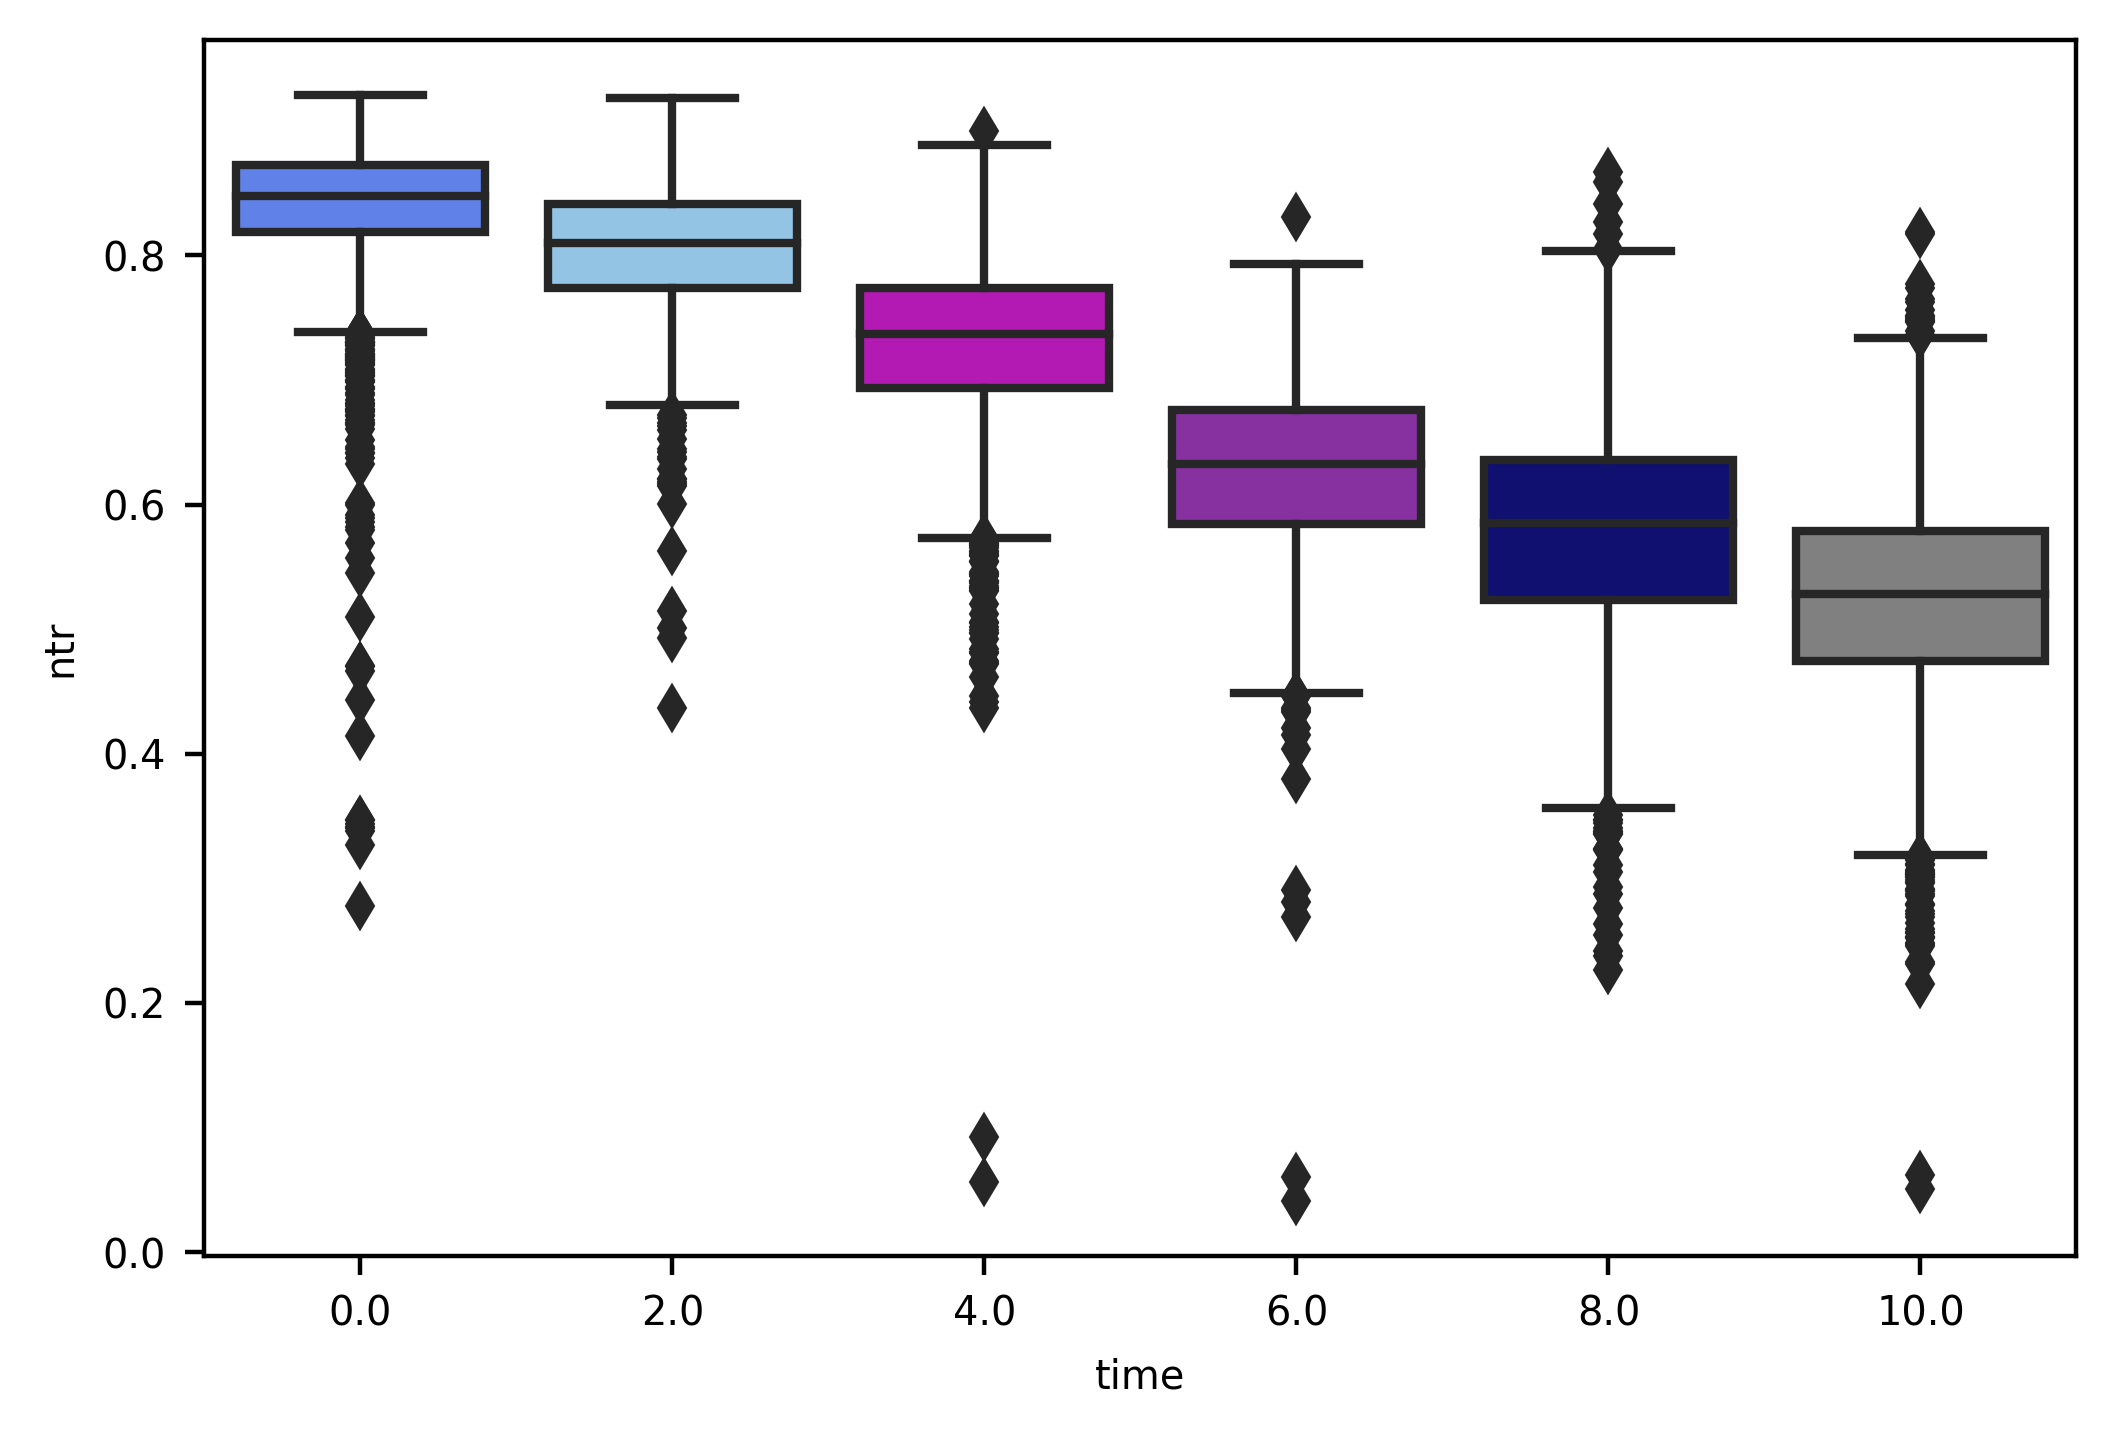

In [12]:
sns.boxplot(data = subset.obs,x='time',y='ntr')

In [13]:
t = subset.obs['time'].values.flatten()
t_uniq = np.unique(t)
r2 = np.zeros_like(gamma_vec2)

for i, gene in enumerate(genes):
    y = np.asarray(subset[:, gene].layers['ntr']).flatten()
    y_avg = np.asarray([np.mean(y[t == cur_t]) for cur_t in t_uniq])
    
    if y_avg.mean() > 1e-2:
        y0, y0, gamma_neg = exp_est(t_uniq, y_avg)
        gamma = - gamma_neg

        gamma_vec[i], half_life[i] = gamma, np.log(2) / gamma

        y_avg_min_t, y_avg_max_t = y_avg[np.argmin(t_uniq)], y_avg[np.argmax(t_uniq)]
        gamma_guess = np.log(y_avg_max_t / (y_avg_min_t + 1e-5)) / (np.min(t_uniq) - np.max(t_uniq))
        p, cov = curve_fit(myexp, t_uniq, y_avg, 
                           p0=[0.01, y_avg[np.argmin(t_uniq)], max(1e-3, gamma_guess)], 
                           maxfev=10000, bounds=(0, [1, 1, 1000]),
                          )
        gamma_vec2[i], half_life2[i] = p[2], np.log(2) / p[2]
        r2[i] = calc_R2(t_uniq, y_avg, p, myexp)

len(gamma_vec2)

5434

Import the mRNA half lives from the 2018 Schwanhauser paper (bulk timelapse-seq)

In [14]:
time_lapse_seq = pd.read_excel(os.path.join(working_directory,'41592_2018_BFnmeth4582_MOESM5_ESM.xls'), index_col=0)
time_lapse_seq

,theta_n1,theta_n2,half_life_rep1,half_life_rep2,mean_half_life
transcript,,,,,
AAGAB,0.263089,0.247941,2.270470,2.432601,2.351535
AAMP,0.130572,0.078293,4.953882,8.501940,6.727911
AAR2,0.677745,0.697201,0.612099,0.580192,0.596145
AARS,0.331817,0.283202,1.719147,2.081768,1.900458
AARS2,0.385144,0.328434,1.425150,1.740953,1.583052
...,...,...,...,...,...
ZYG11A,0.627608,0.684170,0.701702,0.601403,0.651552
ZYG11B,0.609783,0.581157,0.736565,0.796484,0.766524
ZYX,0.206216,0.232363,3.001372,2.621204,2.811288


In [15]:
valid_genes = time_lapse_seq.index.intersection(genes)

In [17]:
df = pd.DataFrame({'time_lapse_seq': time_lapse_seq.loc[valid_genes, 'mean_half_life'],
                  'dynamo': pd.Series(half_life2, index = genes)[valid_genes],
                   'dynamo_r2': pd.Series(r2, index = genes)[valid_genes],
                  }, index=valid_genes)

/home/jmartinr/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


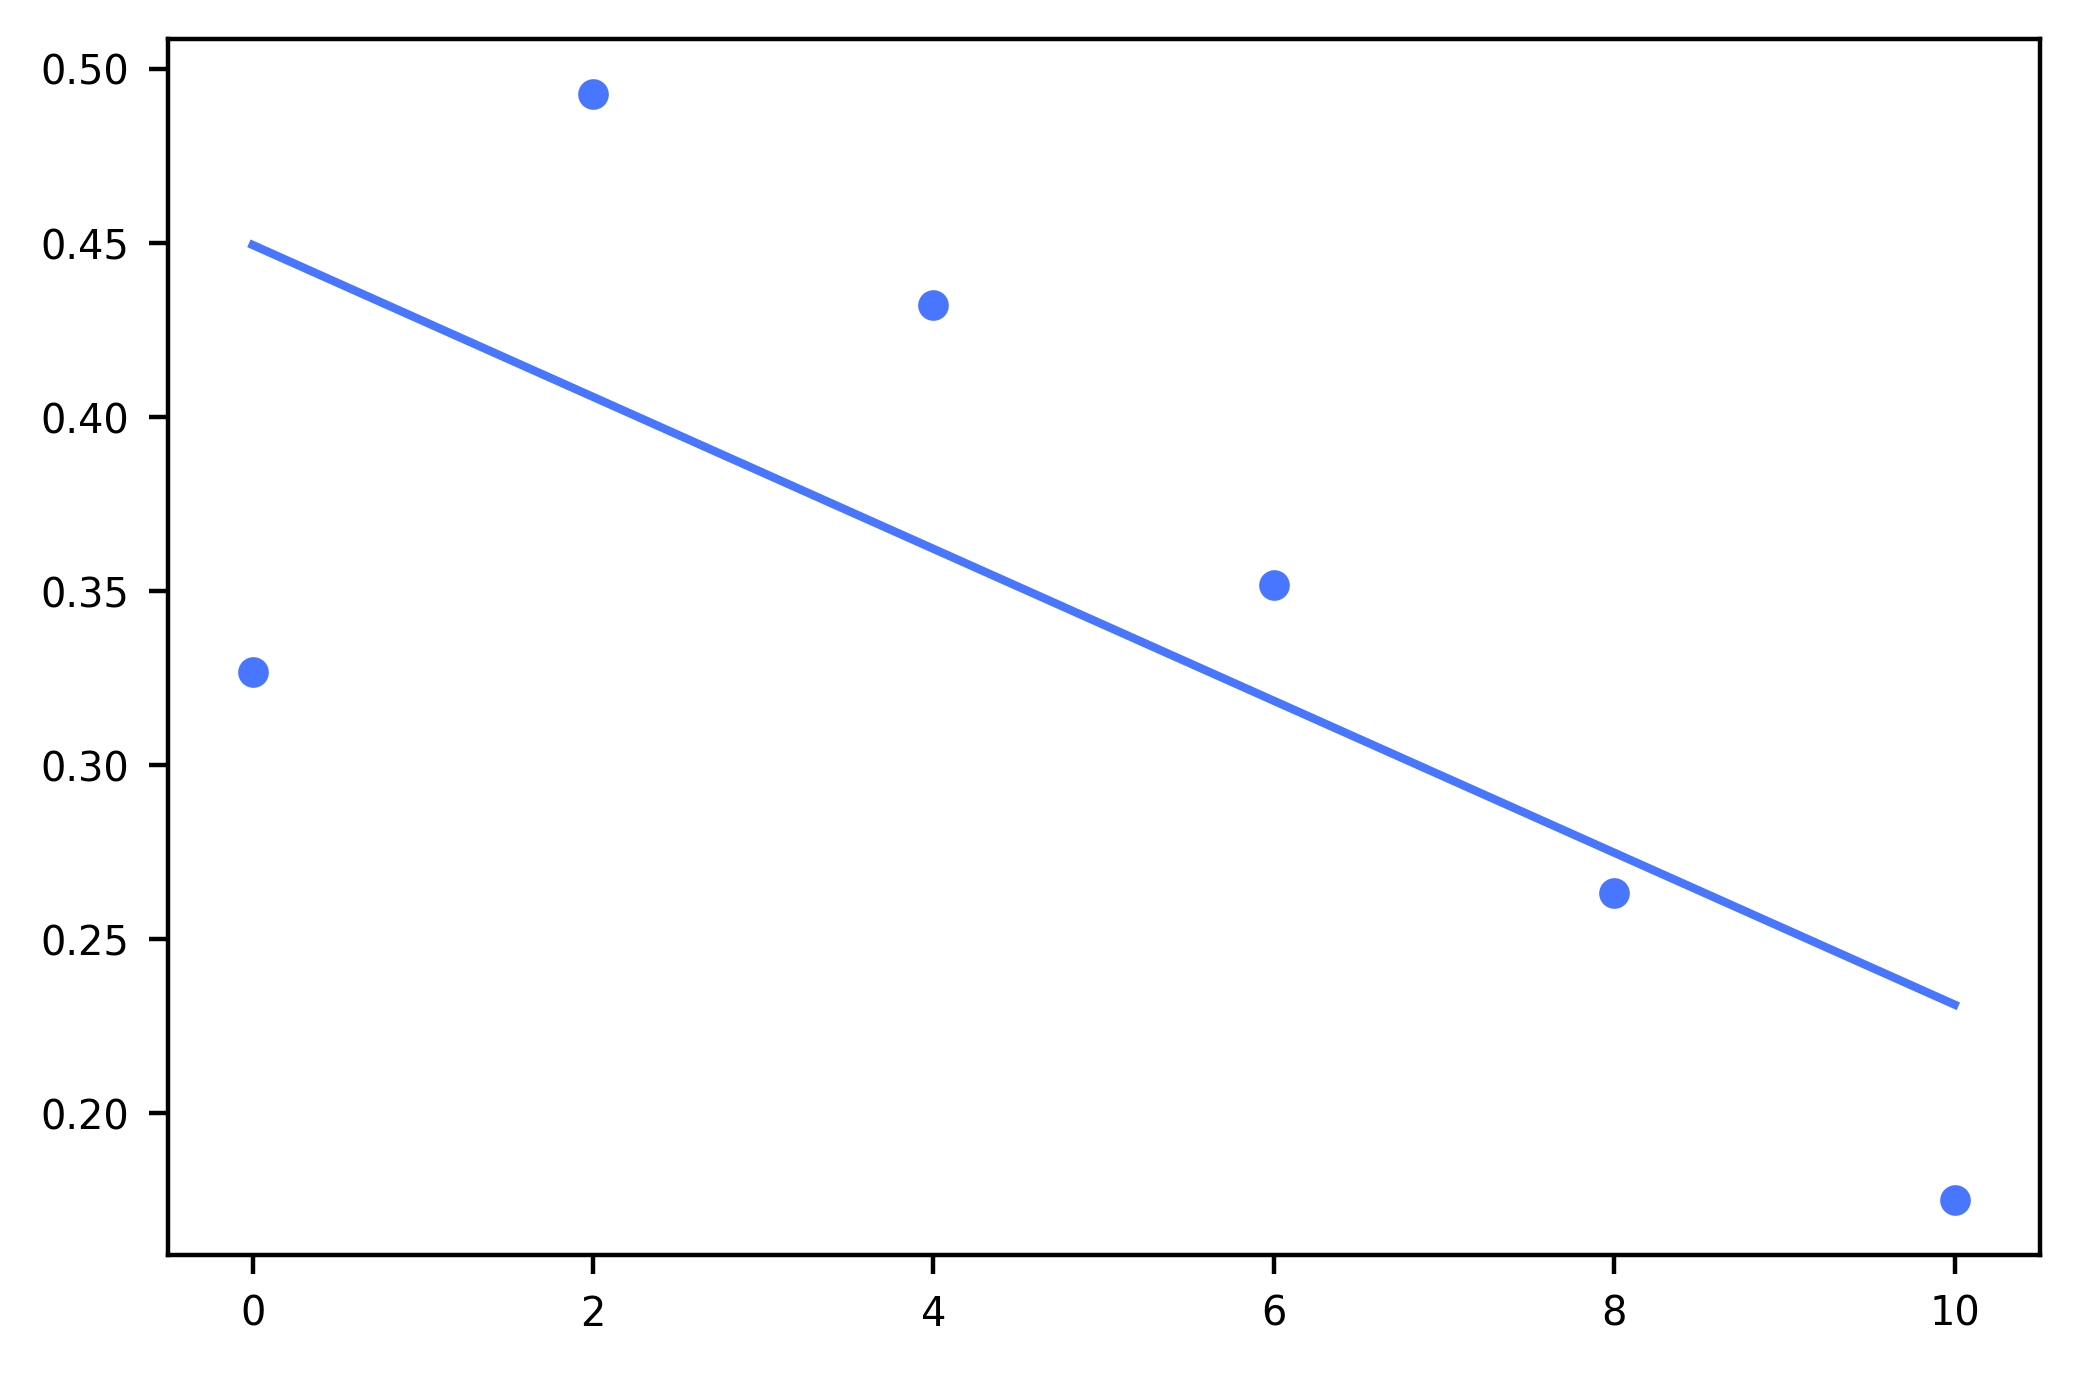

In [22]:
for i, gene in enumerate(genes[genes == 'GATA1']):
    y = np.asarray(subset[:, gene].layers['ntr']).flatten()
    y_avg = np.asarray([np.mean(y[t == cur_t]) for cur_t in t_uniq])
    plt.figure()
    ax = sns.scatterplot(t_uniq, y_avg)
    
    y_avg_min_t, y_avg_max_t = y_avg[np.argmin(t_uniq)], y_avg[np.argmax(t_uniq)]
    gamma_guess = np.log(y_avg_max_t / (y_avg_min_t + 1e-5)) / (np.min(t_uniq) - np.max(t_uniq))
    p, cov = curve_fit(myexp, t_uniq, y_avg, p0=[0.01, y_avg[np.argmin(t_uniq)], gamma_guess], maxfev=2000)

    ax.plot(np.linspace(0, 10, 100), myexp(np.linspace(0, 10, 100), *p))


In [26]:
bad_genes = np.zeros(len(valid_genes))
for i, gene in enumerate(valid_genes):
    y = np.asarray(subset[:, gene].layers['ntr']).flatten()
    xx = y # pass the fraction of labeled RNA for each here
    yy = t # chase time for each cell 
    xm, ym = np.mean(xx), np.mean(yy)
    cov = np.mean(xx * yy) - xm * ym
    var_x = np.mean(xx * xx) - xm * xm
    k = cov / var_x
# if k is positive (labeled RNa fraction increases, it is a bad gene)
    bad_genes[i] = True if k > 0 else False

In [27]:
df_filtered = df

In [28]:
df_filtered=df_filtered[bad_genes == 0]

In [30]:
df_filtered_2 = df_filtered
df_filtered_2=df_filtered_2.rename(columns={"dynamo_r2": "fitting_r2", "dynamo": "stochastic_reg_half_life"})

You can find the half lives estimated in our experiment in the following file (available in https://drive.google.com/drive/folders/1yRjtlSZtXAlCW754Zo3OkRX31xi3bcRT?usp=sharing), together with the r2 fitting:

In [68]:
df_filtered_2.to_csv(os.path.join(working_directory,'stochastic_regulation_half_lives.csv'), index=True)  

In [33]:
df_filtered_2

,time_lapse_seq,stochastic_reg_half_life,fitting_r2
AAGAB,2.351535,35.027267,0.249295
AAMP,6.727911,105.556459,0.013704
AAR2,0.596145,7.877894,0.697148
AARS,1.900458,9.388820,0.864216
AASDHPPT,3.127851,16.204842,0.675814
...,...,...,...
ZW10,2.739958,17.097239,0.595028
ZWINT,4.235759,27.956712,0.529623
ZYG11B,0.766524,14.575818,0.407225
ZZEF1,1.229188,11.876016,0.723749


## Panel S4F:

/home/jmartinr/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


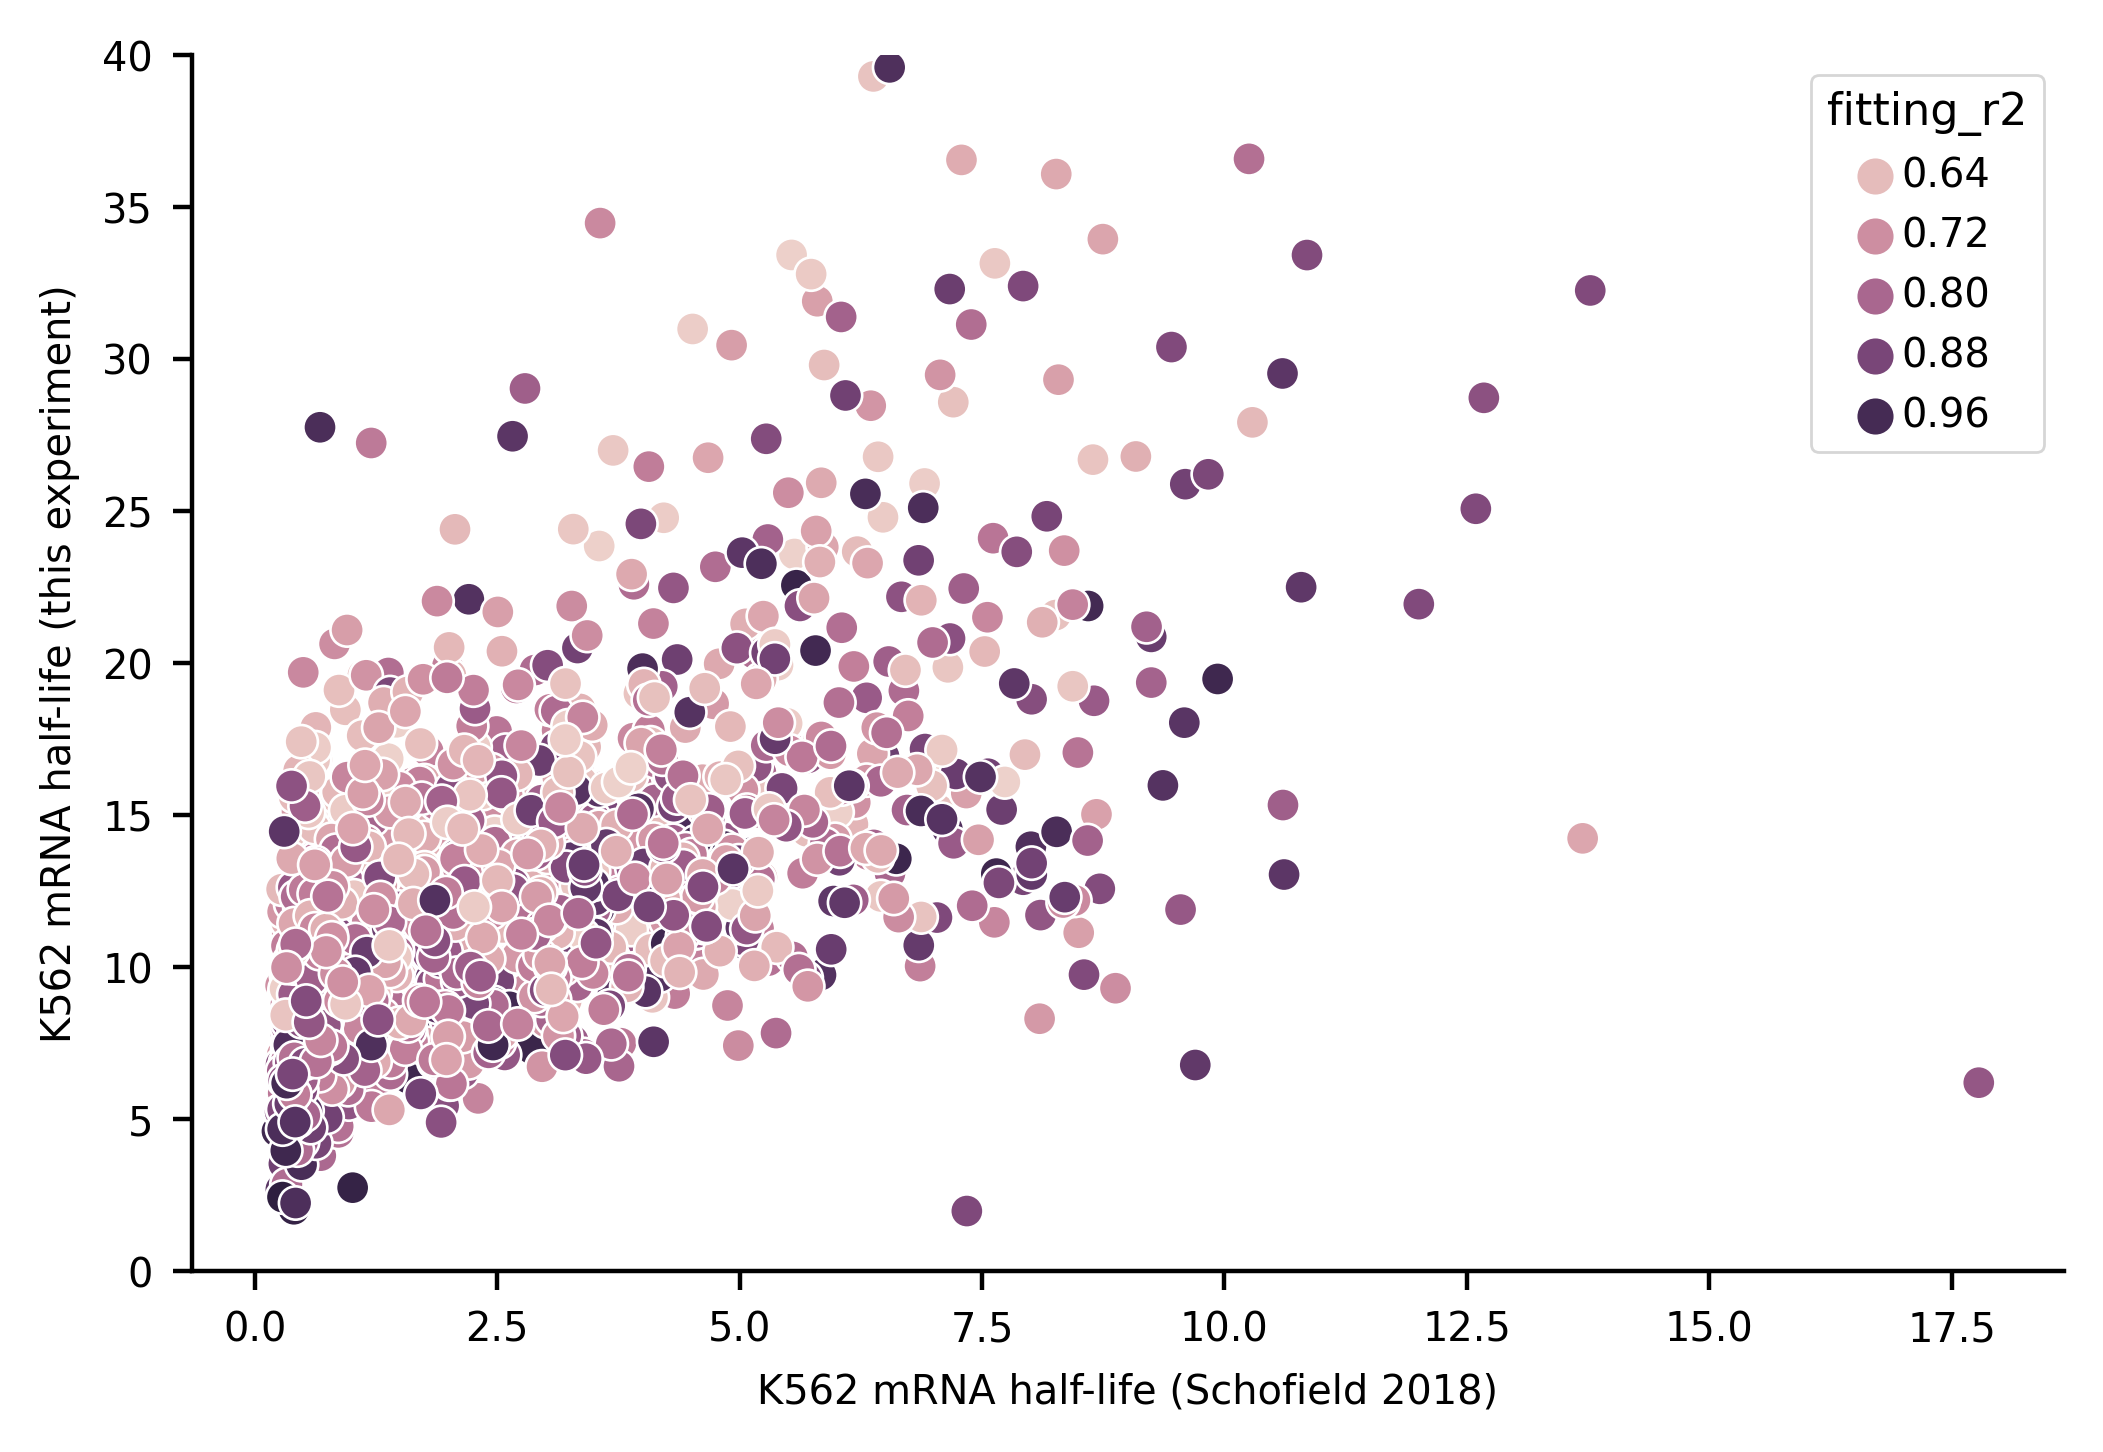

In [36]:
ax = sns.scatterplot('time_lapse_seq','stochastic_reg_half_life',  hue='fitting_r2', data=df_filtered_2.query('fitting_r2 > 0.6'))
ax.set_ylim(0, 40)
ax.set(ylabel='K562 mRNA half-life (this experiment)', xlabel='K562 mRNA half-life (Schofield 2018)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('/home/jmartinr/stochastic_regulation_paper_outputs/S4I.pdf')

Plot the fit in the pulse-chase experiment

/home/jmartinr/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jmartinr/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


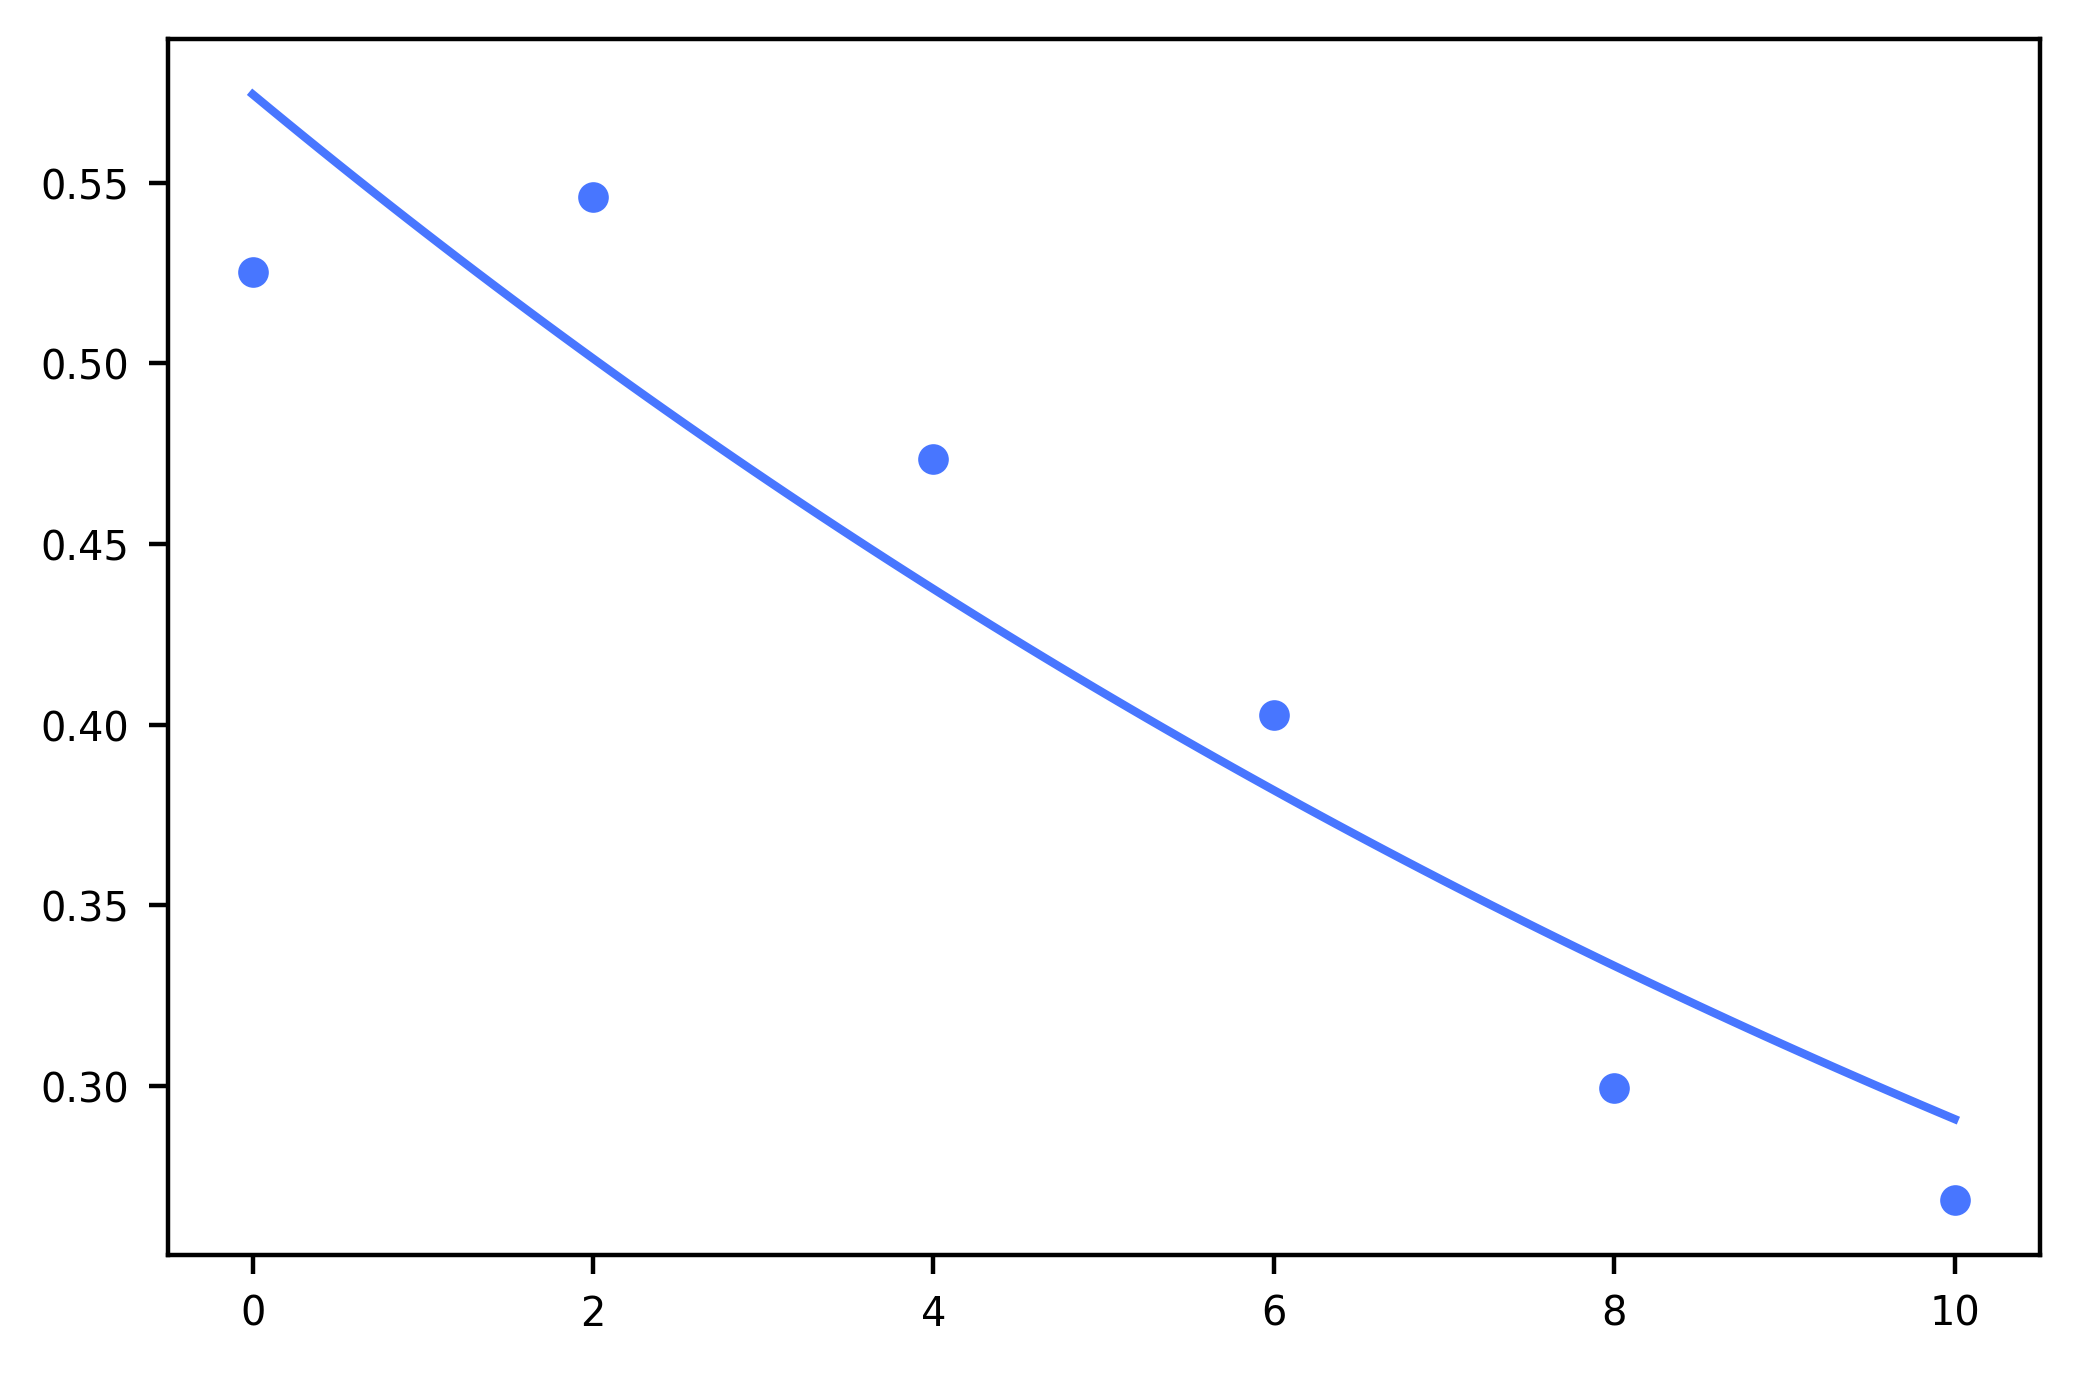

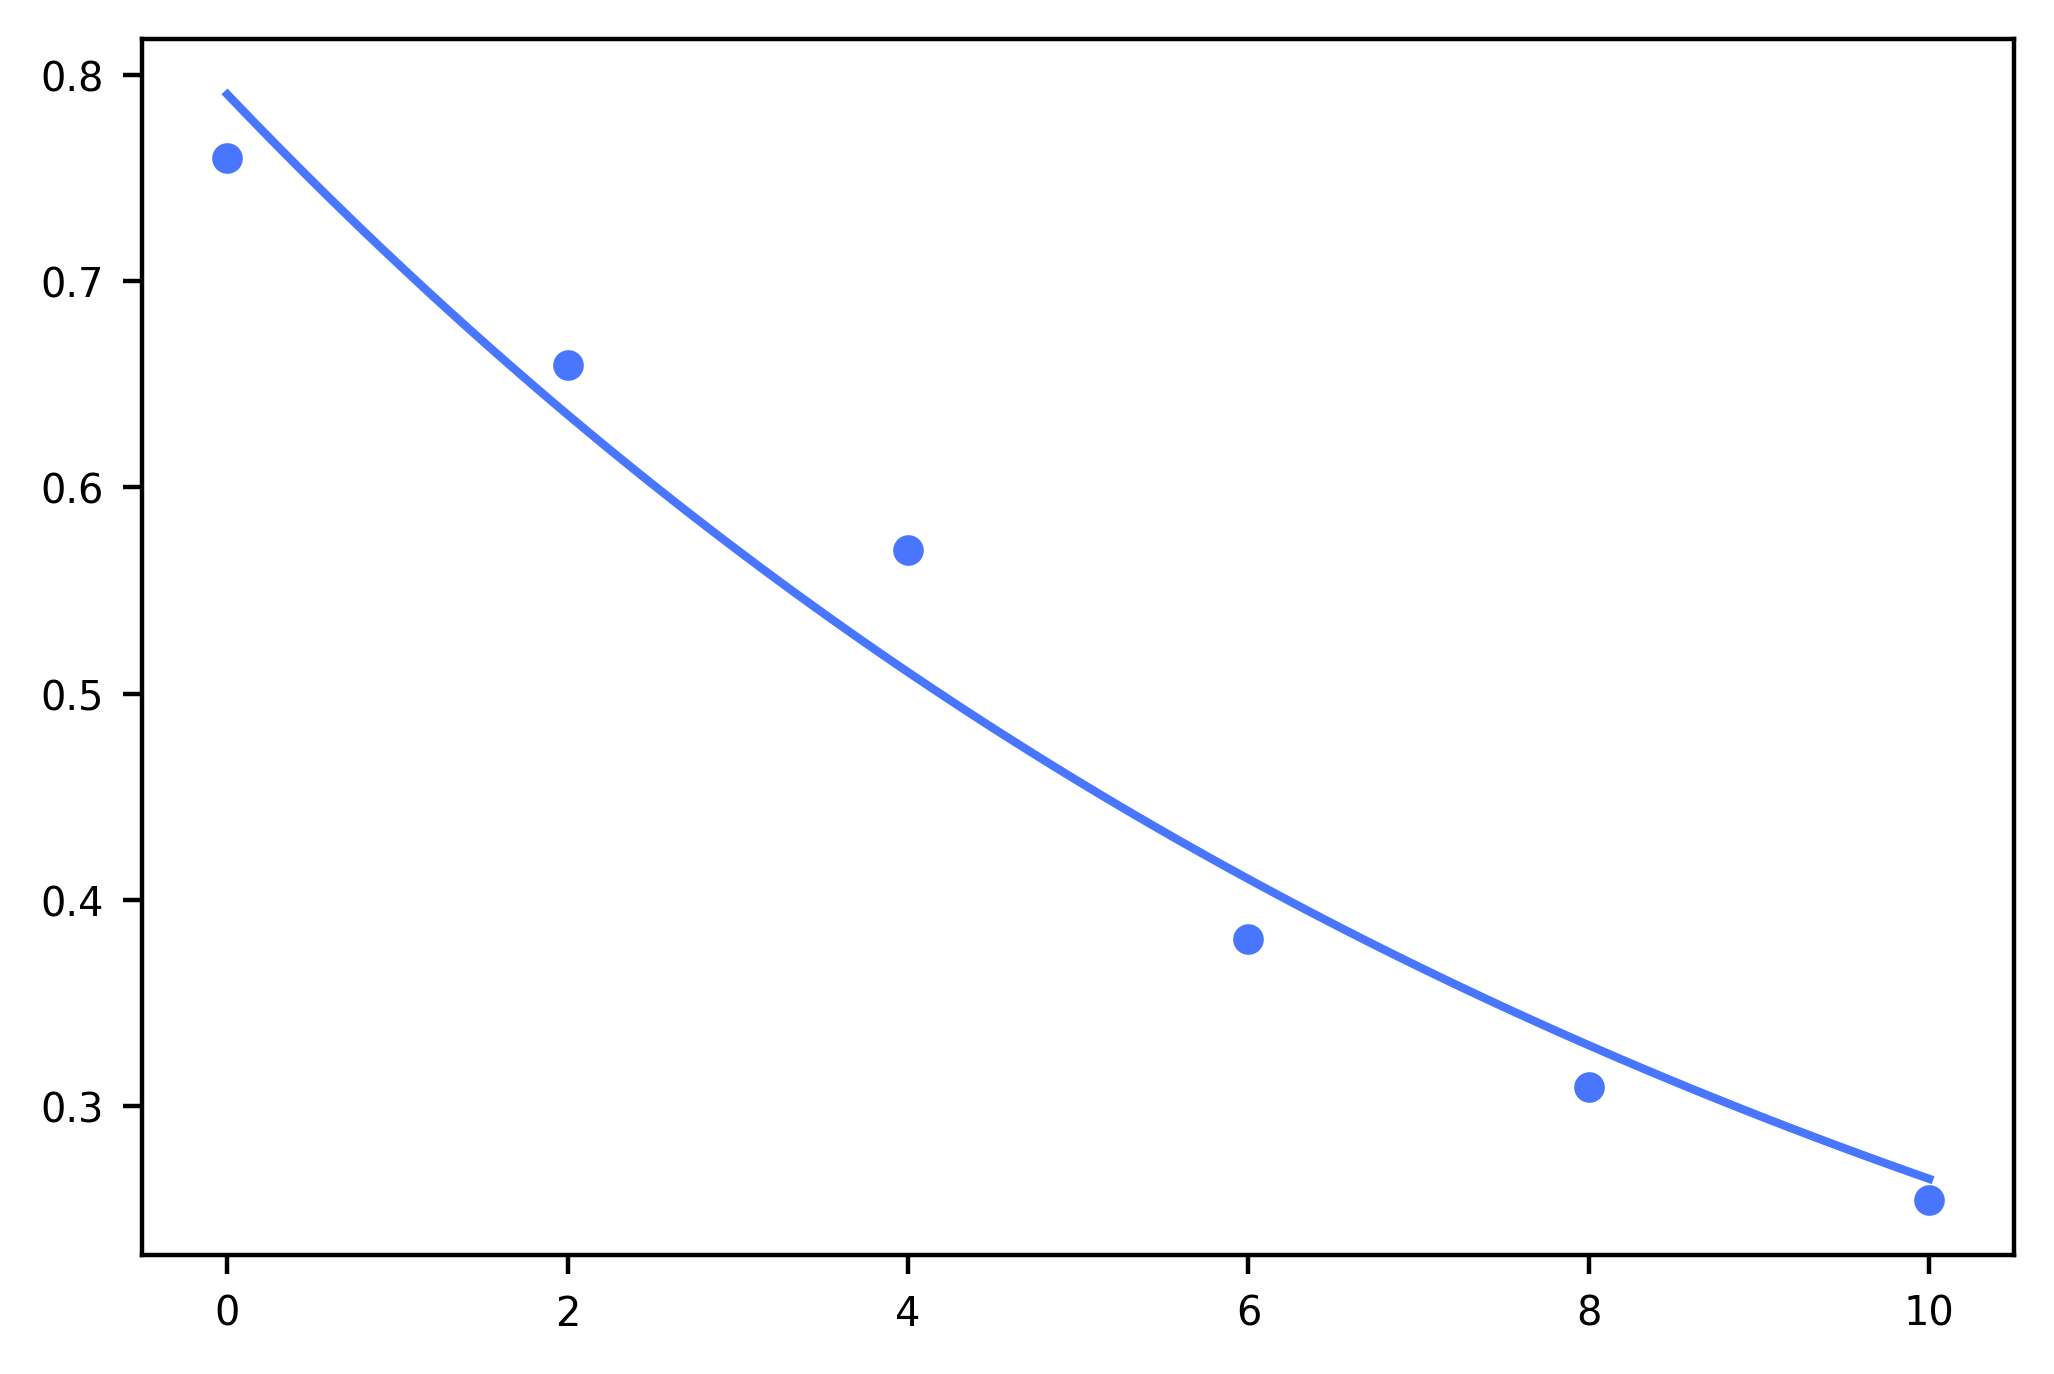

In [40]:
tmax = np.max(t_uniq)

for i, gene in enumerate(subset.var_names[subset.var.use_for_transition][:2]):
    y = np.asarray(subset[:, gene].layers['ntr']).flatten()
    y_avg = np.asarray([np.mean(y[t == cur_t]) for cur_t in t_uniq])
    plt.figure()
    ax = sns.scatterplot(t_uniq, y_avg)
    
    y_avg_min_t, y_avg_max_t = y_avg[np.argmin(t_uniq)], y_avg[np.argmax(t_uniq)]
    gamma_guess = np.log(y_avg_max_t / (y_avg_min_t + 1e-5)) / (np.min(t_uniq) - np.max(t_uniq))
    p, cov = curve_fit(myexp, t_uniq, y_avg, 
                       p0=[0.01, y_avg[np.argmin(t_uniq)], max(1e-3, gamma_guess)], 
                       maxfev=10000, bounds=(0, [1, 1, 1000]),
                      )
    
    ax.plot(np.linspace(0, tmax, 100), myexp(np.linspace(0, tmax, 100), *p))


# calculating bursting size and frequency 

In [41]:
subset

AnnData object with n_obs × n_vars = 14544 × 5434
    obs: 'n_counts', 'n_genes', 'batch', 'time', 'percent_mito', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'gene_name', 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'n_cells-4', 'n_cells-5', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'use_for_dynamics', 'use_for_transition', 'n_cells'
    uns: 'batch_colors', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'neighbors', 'dynamics', 'umap_fit', 'grid_velo

In [42]:
from dynamo.estimation.csc.utils_velocity import compute_dispersion, compute_bursting_properties, find_extreme

In [43]:
gamma_vec2 = gamma_vec2.astype(float)

In [44]:
len(genes)

5434

In [ ]:
test = subset.copy()
bs, bf = np.zeros(len(genes)), np.zeros(len(genes))
for i, gene in enumerate(genes):
    s, ss = test[:, gene].layers['M_s'].A, test[:, gene].layers['M_ss'].A
    u = test[:, gene].layers['M_u'].A
    mask = find_extreme(
                s,
                u,
                perc_left=None,
                perc_right=5,
                normalize=True,
            )
    phi = compute_dispersion(s, ss)
    gamma = gamma_vec2[i]
    bs[i], bf[i] = compute_bursting_properties(np.mean(u[mask] + s[mask]), phi, gamma)

/home/jmartinr/.local/lib/python3.6/site-packages/dynamo/estimation/csc/utils_velocity.py:283: RuntimeWarning: invalid value encountered in float_scalars
  k = cov / var_x


In [56]:
bs_bf_df = pd.DataFrame({'bs': bs, 
                         'bf': bf,
                         'log10bf' : np.log10(bf),
                         'log10bs' : np.log10(bs),
                         'dynamo_r2': pd.Series(r2, index = genes),
                         'gamma': pd.Series(gamma_vec2, index = genes),
                         'dynamo_half_life': pd.Series(half_life2, index = genes)[valid_genes],
                         '1/dynamo_half_life': pd.Series(1/half_life2, index = genes)[valid_genes],
                         'time_lapse_seq_half_life': time_lapse_seq.loc[valid_genes, 'mean_half_life'],
                  }, index=genes)

/home/jmartinr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jmartinr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jmartinr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/jmartinr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [57]:
bs_bf_df.sort_values('bs', ascending=False)

,bs,bf,log10bf,log10bs,dynamo_r2,gamma,dynamo_half_life,1/dynamo_half_life,time_lapse_seq_half_life
MT-RNR2,267.393097,2.264127e-01,-0.645099,2.427150,9.889086e-01,2.691236e-01,NaN,NaN,NaN
HBG2,237.017593,4.118543e-17,-16.385256,2.374781,3.787186e-08,5.046869e-17,1.373420e+16,7.281093e-17,18.622848
MT-ATP6,201.254242,9.105600e-02,-1.040691,2.303745,9.990764e-01,1.073225e-01,NaN,NaN,NaN
HBG1,200.874481,7.596818e-17,-16.119368,2.302925,2.475870e-08,9.263670e-17,7.482425e+15,1.336465e-16,12.317257
MT-ND4,103.158340,1.608822e-01,-0.793492,2.013504,9.996594e-01,1.830741e-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
STAG2,-48.537563,-3.639040e-04,NaN,NaN,7.351834e-01,4.011452e-02,1.727921e+01,5.787302e-02,2.749012
MGST1,NaN,NaN,NaN,NaN,1.943616e-01,2.919129e-02,NaN,NaN,NaN
MTERF1,NaN,NaN,NaN,NaN,8.126459e-01,1.350110e-01,NaN,NaN,NaN
GPM6A,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN


You can find the burst sizes and frequencies estimated in our experiment in the following file (available in https://drive.google.com/drive/folders/1yRjtlSZtXAlCW754Zo3OkRX31xi3bcRT?usp=sharing):

In [70]:
bs_bf_df.to_csv(os.path.join(working_directory,'stochastic_regulation_burst_sizes.csv'), index=True)  

In [58]:
bs_bf_df.query('bs < 0').sort_values('bs', ascending=False)

,bs,bf,log10bf,log10bs,dynamo_r2,gamma,dynamo_half_life,1/dynamo_half_life,time_lapse_seq_half_life
GOSR2,-0.000098,-3.733609e-02,NaN,NaN,5.891714e-01,8.155818e-02,NaN,NaN,NaN
KDELR2,-0.001744,-7.356225e-04,NaN,NaN,7.490025e-01,4.514398e-02,NaN,NaN,NaN
ZNF551,-0.001789,-5.214479e-03,NaN,NaN,9.520074e-01,1.468364e-01,NaN,NaN,NaN
BABAM1,-0.002343,-1.030536e-03,NaN,NaN,1.995165e-01,2.855537e-02,NaN,NaN,NaN
PPP2CB,-0.583310,-2.632289e-02,NaN,NaN,5.420446e-01,2.984947e-02,23.221420,0.043064,2.269850
TRIM13,-0.832413,-1.114989e-02,NaN,NaN,8.341237e-01,5.494849e-02,12.614490,0.079274,0.399576
NFE2L2,-2.566599,-1.662355e-02,NaN,NaN,8.555822e-01,1.140577e-01,6.077165,0.164550,0.335615
FGD5-AS1,-2.746597,-1.986152e-03,NaN,NaN,7.067033e-01,5.609838e-02,12.355922,0.080933,1.851507
ZNF83,-3.008450,-2.407952e-02,NaN,NaN,7.141098e-01,6.597009e-02,10.506992,0.095175,0.738642
WDR20,-5.203197,-2.123591e-03,NaN,NaN,4.012447e-01,5.325733e-02,13.015057,0.076834,0.499316


In [59]:
bs_bf_df_positive_bs = bs_bf_df.query('bs > 0').sort_values('bs', ascending=False)

In [60]:
bs_bf_df_positive_bs.query('dynamo_r2 > 0.4').sort_values('bs', ascending=False)

,bs,bf,log10bf,log10bs,dynamo_r2,gamma,dynamo_half_life,1/dynamo_half_life,time_lapse_seq_half_life
MT-RNR2,267.393097,0.226413,-0.645099,2.427150,0.988909,0.269124,NaN,NaN,NaN
MT-ATP6,201.254242,0.091056,-1.040691,2.303745,0.999076,0.107322,NaN,NaN,NaN
MT-ND4,103.158340,0.160882,-0.793492,2.013504,0.999659,0.183074,NaN,NaN,NaN
INO80D,101.615067,0.076511,-1.116274,2.006958,0.774533,0.091570,7.569564,0.132108,0.346906
MTATP6P1,92.087936,0.090304,-1.044294,1.964203,0.997504,0.108630,6.380826,0.156720,0.751108
...,...,...,...,...,...,...,...,...,...
DDX39B,0.154951,0.013821,-1.859459,-0.809806,0.811452,0.056105,NaN,NaN,NaN
RPP21,0.131068,0.100313,-0.998642,-0.882504,0.544277,0.062026,NaN,NaN,NaN
BLOC1S6,0.096665,0.005339,-2.272556,-1.014730,0.565473,0.034445,NaN,NaN,NaN
MATR3,0.090230,0.050623,-1.295656,-1.044650,0.412933,0.067685,10.240736,0.097649,4.299190


<AxesSubplot:xlabel='bf', ylabel='Count'>

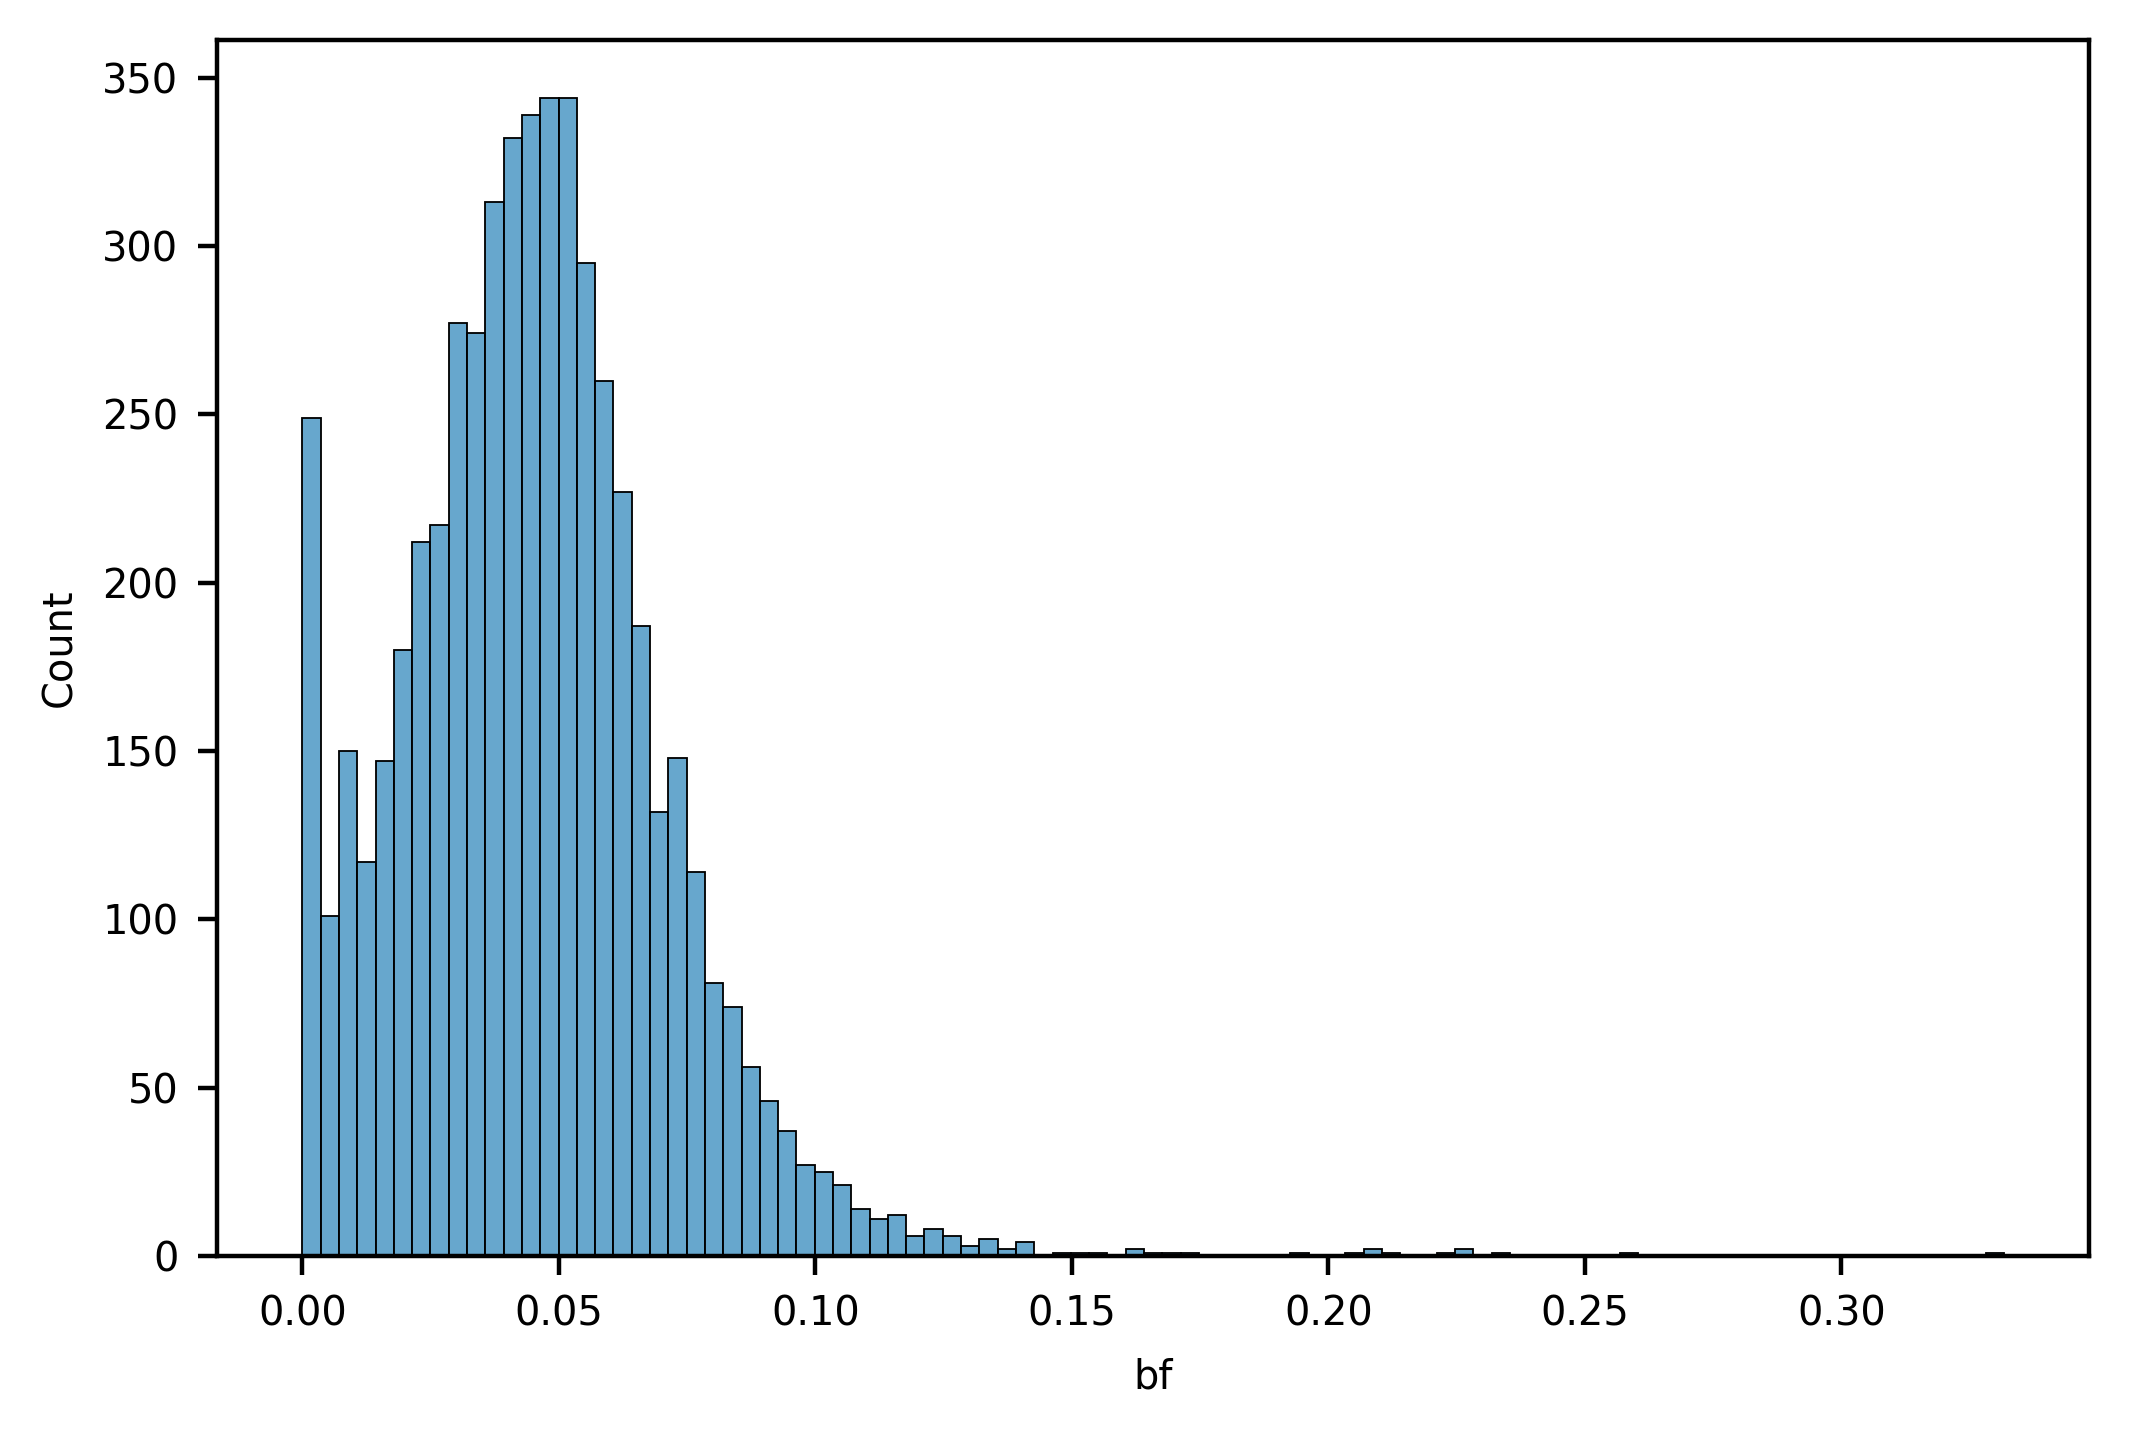

In [63]:
sns.histplot(data=bs_bf_df_positive_bs, x="bf")

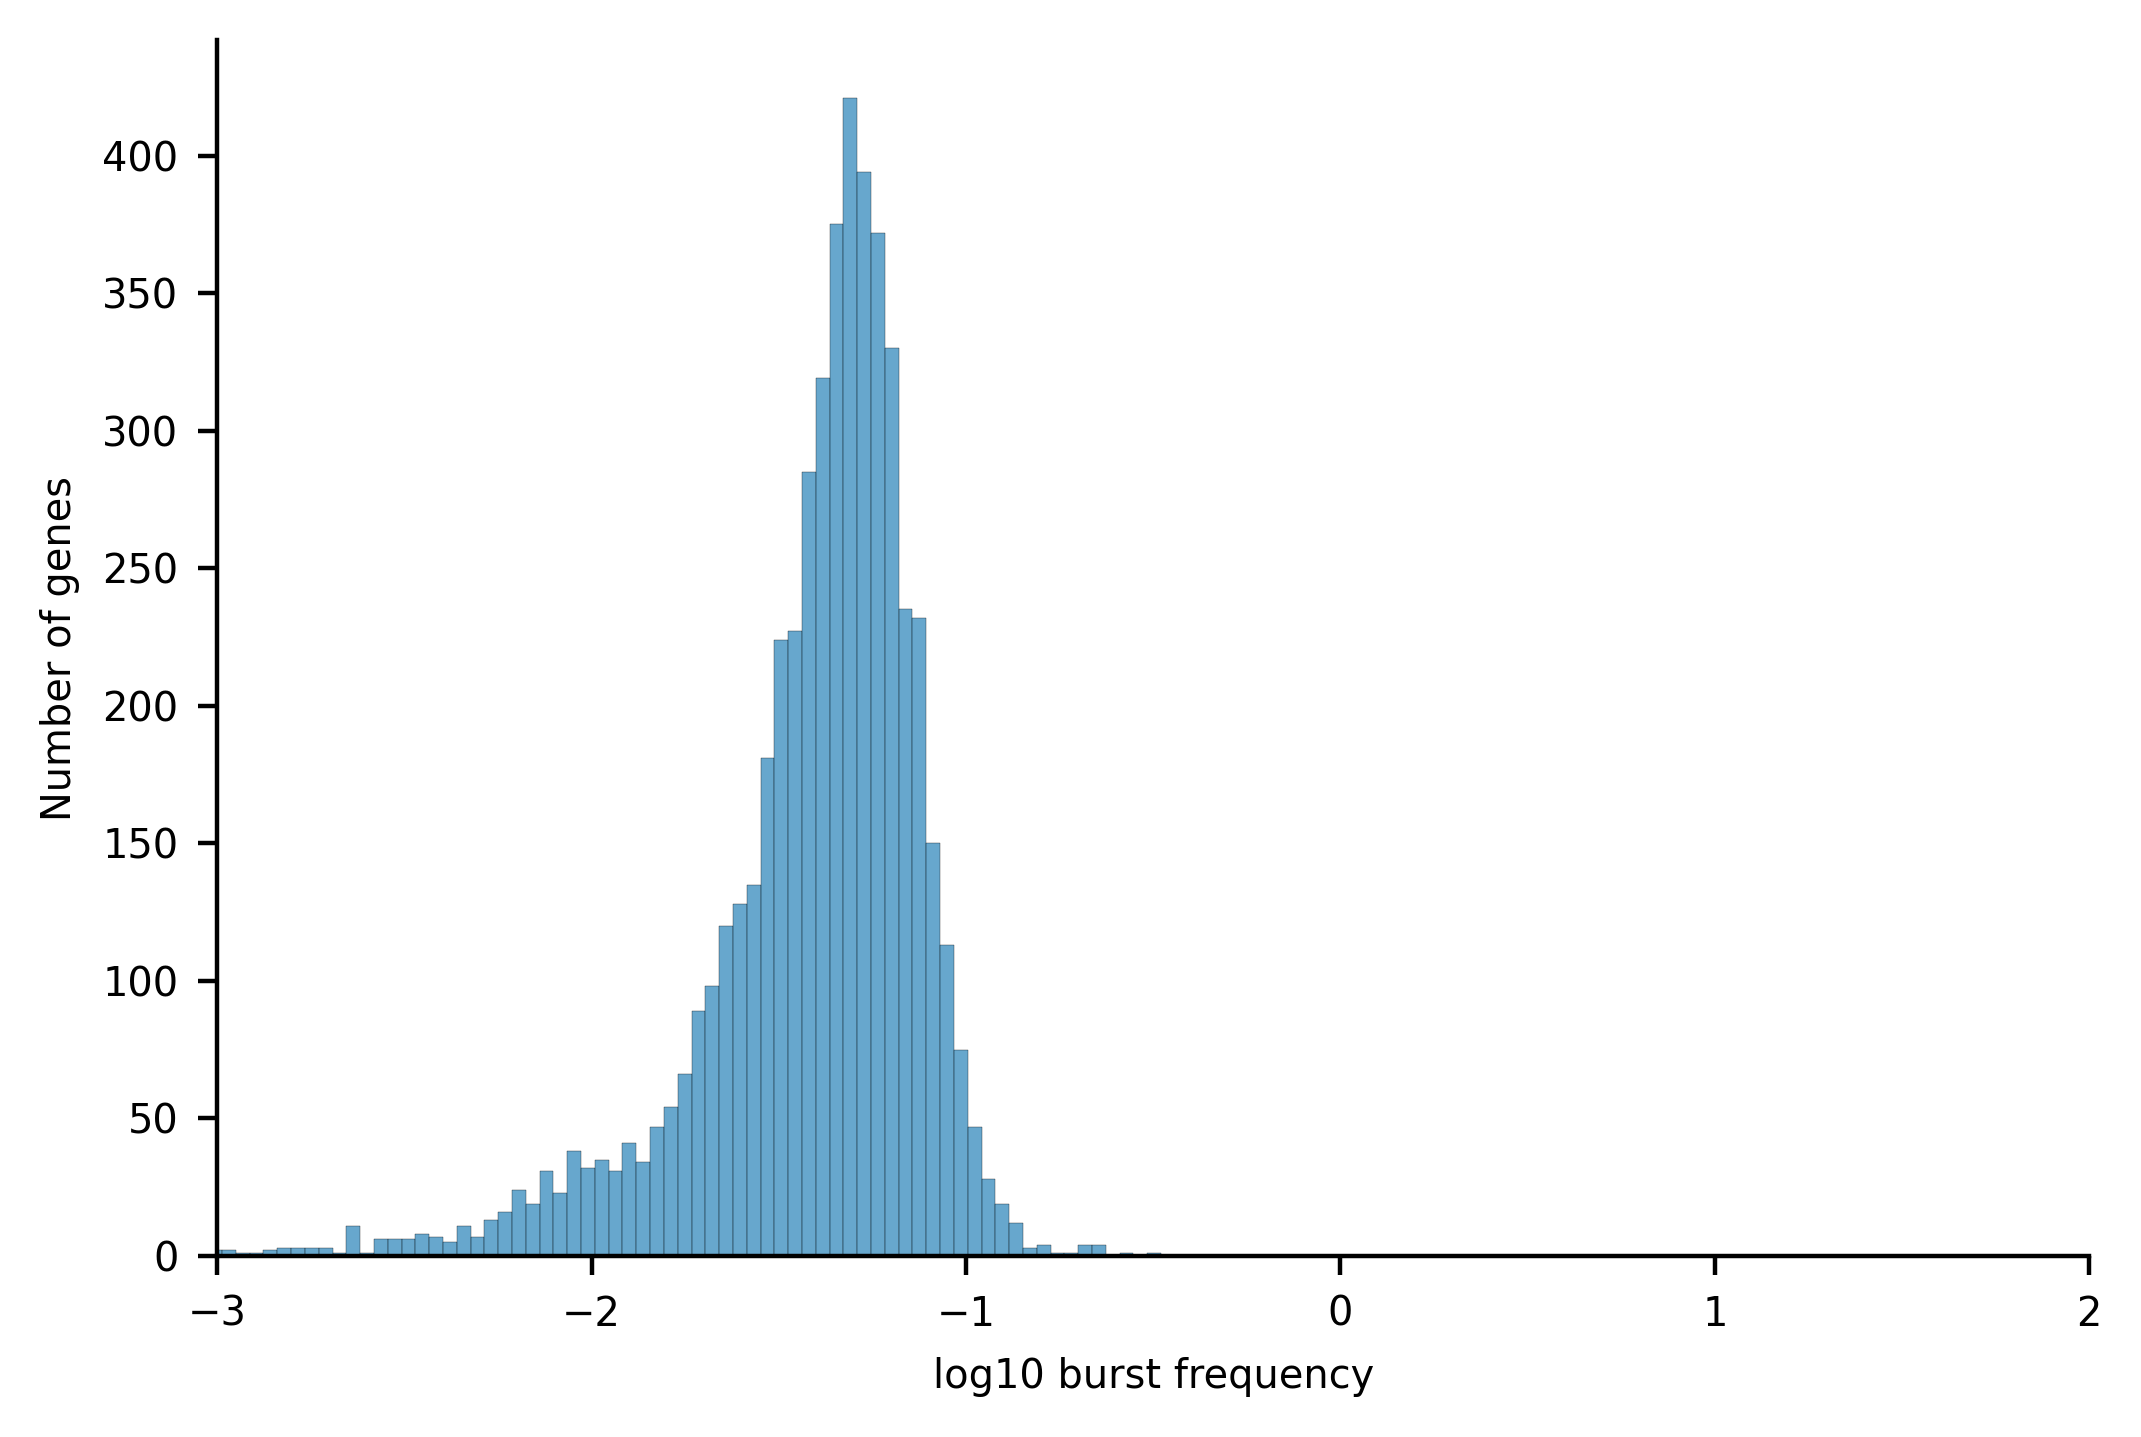

In [66]:
ax=sns.histplot(data=bs_bf_df_positive_bs[np.isfinite(bs_bf_df_positive_bs['log10bf'])], x="log10bf")
ax.set(xlabel='log10 burst frequency', ylabel='Number of genes')
ax.set_xlim([-3, 2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## Panel S4E:

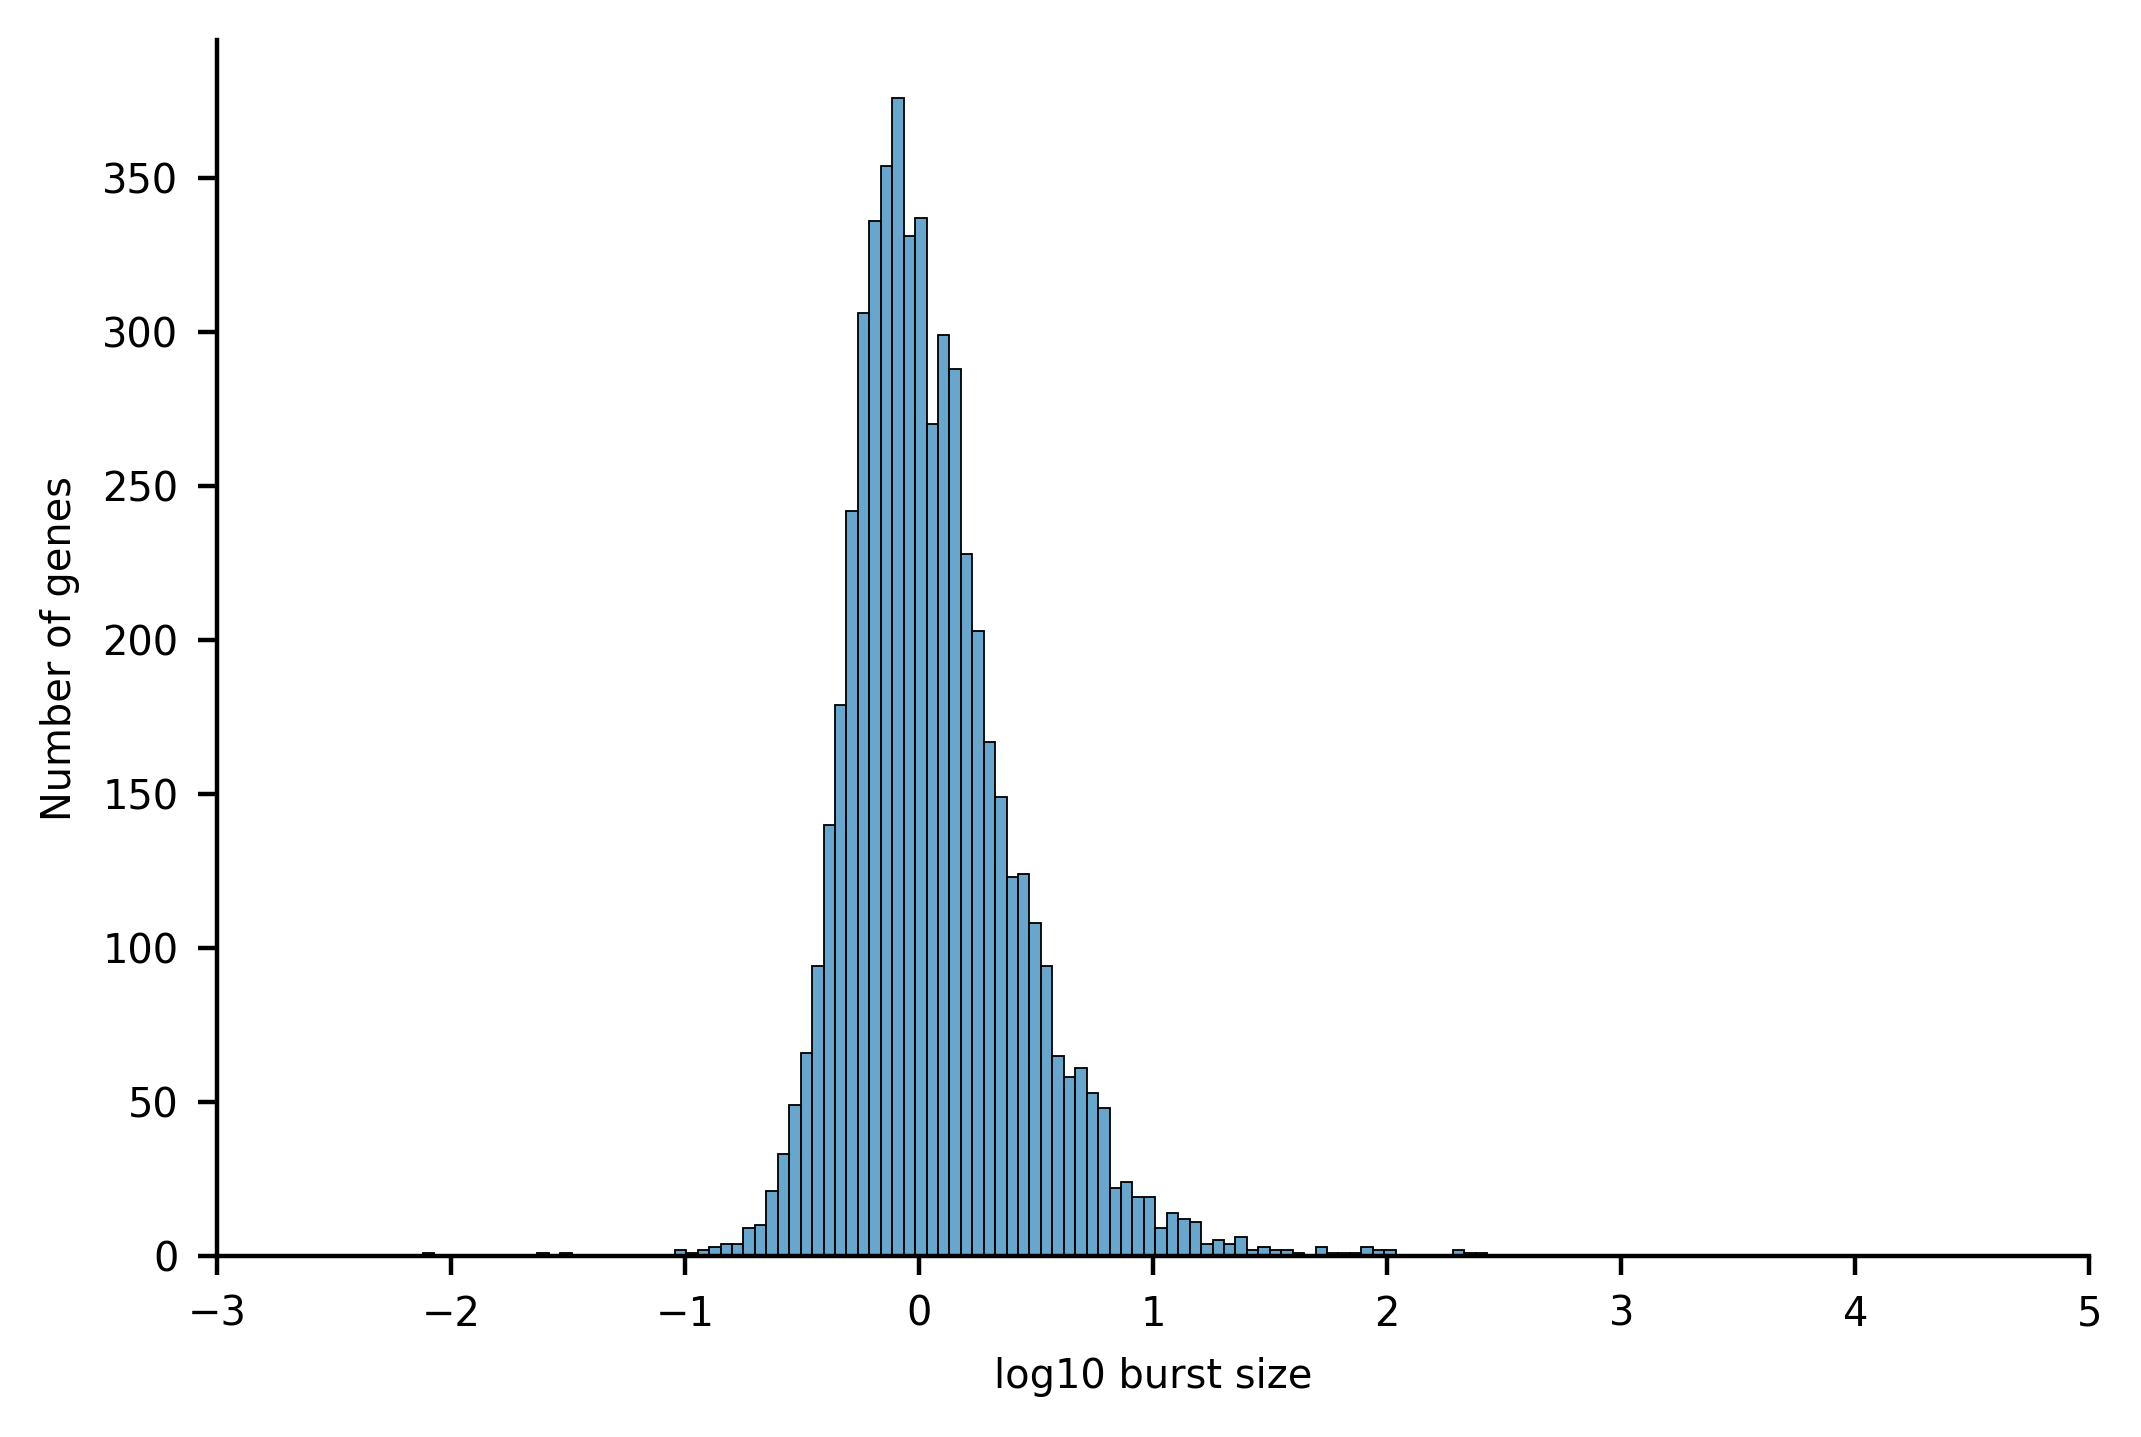

In [69]:
ax=sns.histplot(data=bs_bf_df_positive_bs[np.isfinite(bs_bf_df_positive_bs['log10bs'])], x="log10bs")
ax.set(xlabel='log10 burst size', ylabel='Number of genes')
ax.set_xlim([-3, 5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('/home/jmartinr/stochastic_regulation_paper_outputs/S4H.pdf')